In [27]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pykrx import stock
import torch.nn as nn 


# df = stock.get_index_ohlcv_by_date("20100101", "20211231", "1001")


,Unnamed: 0,집계일시,평균속도
0,0,2021050100,98.63
1,1,2021050101,100.53
2,2,2021050102,99.86
3,3,2021050103,99.34
4,4,2021050104,93.64


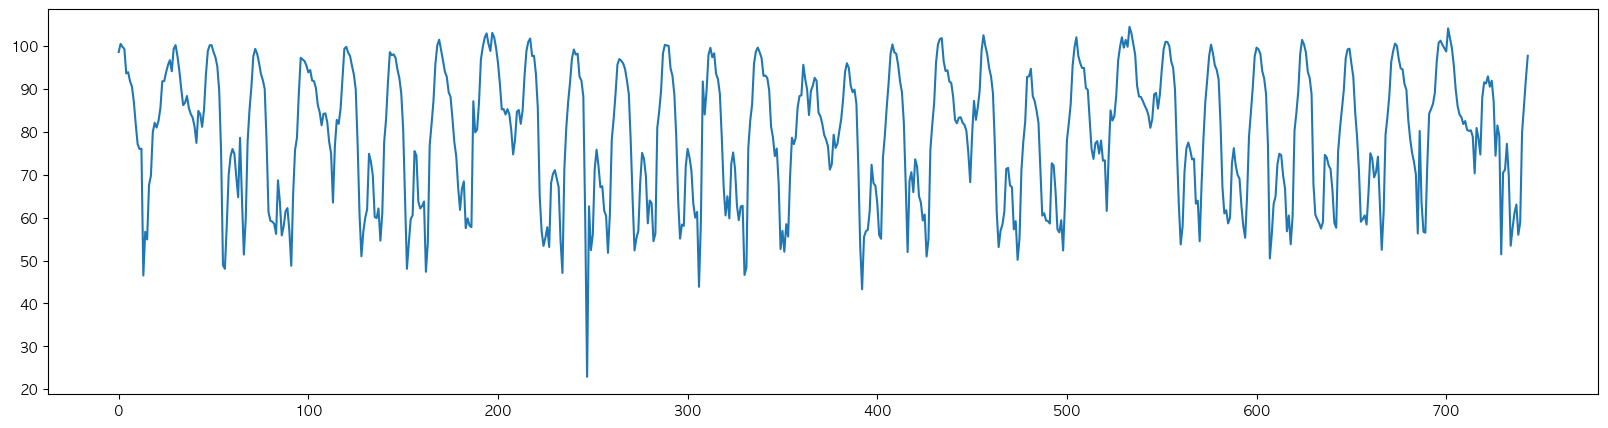

In [36]:
rawdata = pd.read_csv("data/서인천IC-부평IC 평균속도.csv", encoding='CP949')
plt.figure(figsize=(20,5))
plt.plot(range(len(rawdata)), rawdata["평균속도"])
rawdata.head()

In [37]:
rawdata.shape

(744, 3)

In [40]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
rawdata["평균속도"] = min_max_scaler.fit_transform(rawdata["평균속도"].to_numpy().reshape(-1,1))

In [39]:
rawdata["평균속도"].to_numpy().reshape(-1,1) # 1열로 지정 

array([[ 98.63],
       [100.53],
       [ 99.86],
       [ 99.34],
       [ 93.64],
       [ 93.92],
       [ 91.78],
       [ 90.57],
       [ 87.03],
       [ 81.75],
       [ 77.13],
       [ 76.01],
       [ 76.09],
       [ 46.5 ],
       [ 56.69],
       [ 54.91],
       [ 67.57],
       [ 69.82],
       [ 79.98],
       [ 82.14],
       [ 81.02],
       [ 82.58],
       [ 85.55],
       [ 91.8 ],
       [ 91.87],
       [ 93.9 ],
       [ 95.61],
       [ 96.73],
       [ 94.15],
       [ 99.36],
       [100.24],
       [ 97.64],
       [ 94.25],
       [ 90.01],
       [ 86.25],
       [ 86.81],
       [ 88.37],
       [ 85.6 ],
       [ 84.18],
       [ 83.35],
       [ 81.26],
       [ 77.43],
       [ 84.89],
       [ 84.12],
       [ 81.19],
       [ 85.15],
       [ 93.34],
       [ 98.84],
       [100.22],
       [100.22],
       [ 98.65],
       [ 97.45],
       [ 95.32],
       [ 89.67],
       [ 75.37],
       [ 48.91],
       [ 48.06],
       [ 58.29],
       [ 70.01

In [46]:
# 1주일 기준으로 train test 나눠줌 
train = rawdata[:-24*7]
data_train = train["평균속도"].to_numpy()

test = rawdata[-24*7:]
data_test = test["평균속도"].to_numpy()

## 데이터 생성
- X: 2주치가 하나의 데이터로 497개
- y: 1주치가 하나의 데이터로 497개 
- 즉, 2주치로 1주치 예측하는 상황

In [47]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i, :-1], self.y[i,1:]
    def __len__(self):
        return self.len

In [48]:
iw = 24*14
ow = 24*7

train_dataset = windowDataset(data_train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

In [54]:
from torch.nn import Transformer
from torch import nn
import torch
import math

In [65]:
import torch

class MaskGenerator:
    def generate_square_subsequent_mask(self, sz):
        # 상삼각형 마스크 생성
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        # 마스크에서 0인 부분은 -inf로, 1인 부분은 0으로 채우기
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

# MaskGenerator 인스턴스 생성
mask_generator = MaskGenerator()

# 입력 크기 설정
size = 5  # 마스크 크기
mask = mask_generator.generate_square_subsequent_mask(size)

# 결과 출력
print("Generated Square Subsequent Mask:")
print(mask)


Generated Square Subsequent Mask:
tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


In [70]:
(torch.triu(torch.ones(4, 4)) == 1).transpose(0,1)

tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]])

In [72]:
class TFModel(nn.Module):
    def __init__(self,d_model, nhead, nhid, nlayers, dropout=0.5):
        # d_model: 입력데이터 차원수 
        # nhead: 멀티헤드 어텐션 헤드 수 
        super(TFModel, self).__init__()
        self.transformer = Transformer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers,dropout=dropout)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_encoder_d = PositionalEncoding(d_model, dropout)
        self.linear = nn.Linear(d_model, 1) # 차원 1로 변환 
        self.encoder = nn.Linear(1, d_model) # 입력데이터를 d차원으로 변환 
        self.encoder_d = nn.Linear(1, d_model)

    # 현재 시점 이후 데이터에 대해서 마스킹하는 코드 
    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, tgt, srcmask, tgtmask):
        src = self.encoder(src) # 입력 시계열 데이터 
        src = self.pos_encoder(src) # 

        tgt = self.encoder_d(tgt)
        tgt = self.pos_encoder_d(tgt)
        output = self.transformer(src.transpose(0,1), tgt.transpose(0,1), srcmask, tgtmask)
        output = self.linear(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# 패딩 처리 -길이 맞춰주기 위해서 
def gen_attention_mask(x):
    mask = torch.eq(x, 0) 
    return mask

In [73]:
device = torch.device("cpu")

lr = 1e-3
model = TFModel(256, 8, 256, 2, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [74]:
epoch = 100
from tqdm import tqdm

model.train()
progress = tqdm(range(epoch))
for i in progress:
    batchloss = 0.0
    
    for (inputs, dec_inputs, outputs) in train_loader:
        optimizer.zero_grad()
        src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)

        result = model(inputs.float().to(device), dec_inputs.float().to(device), src_mask, tgt_mask)
        loss = criterion(result.permute(1,0,2), outputs.float().to(device))
        
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_loader)))

0.04797:  29%|██▉       | 29/100 [02:24<05:54,  5.00s/it]


KeyboardInterrupt: 